In [91]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

print(os.environ["CUDA_VISIBLE_DEVICES"])
print(torch.cuda.is_available())

3
True


In [ ]:
import numpy as np
import librosa

filename = 'musics/Something Just Like This-5-The Chai....mp3'

y, sr = librosa.load(filename)

In [ ]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr)

In [ ]:
beat_intervals = np.diff(beat_times) # duration of beat(i)
parts_per_beat = 96
divided_beats = []

for i, beat_time in enumerate(beat_times[:-1]):
    step = beat_intervals[i] / parts_per_beat
    divided_beats.append(np.arange(beat_time, beat_time + beat_intervals[i], step))

In [ ]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

In [ ]:
def get_note_from_frequency(frequency):
    midi_num = librosa.hz_to_midi(frequency)
    return int(midi_num)
    # return librosa.midi_to_note(int(midi_num))

notes = []
volumes = []

for i in range(len(beat_times) - 1):
    current_time = beat_times[i]
    next_time = beat_times[i + 1]
    current_sample = librosa.time_to_samples(current_time, sr=sr)
    next_sample = librosa.time_to_samples(next_time, sr=sr)

    # Estimate frequency and volume of the current beat
    current_freq = librosa.yin(y[current_sample:next_sample], fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))
    current_note = get_note_from_frequency(current_freq[0])
    current_volume = np.mean(librosa.amplitude_to_db(np.abs(y[current_sample:next_sample])))

    notes.append(current_note)
    volumes.append(current_volume)

In [ ]:
for i, note in enumerate(notes):
    print(i, note)

In [ ]:
divided_notes = []
divided_volumes = []

for beat_index, beat_pieces in enumerate(divided_beats):
    beat_notes = []
    beat_volumes = []

    for piece_index in range(len(beat_pieces) - 1):
        current_time = beat_pieces[piece_index]
        next_time = beat_pieces[piece_index + 1]
        current_sample = librosa.time_to_samples(current_time, sr=sr)
        next_sample = librosa.time_to_samples(next_time, sr=sr)

        current_freq = librosa.yin(y[current_sample:next_sample], fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))
        current_note = get_note_from_frequency(current_freq[0])
        current_volume = np.mean(librosa.amplitude_to_db(np.abs(y[current_sample:next_sample])))

        beat_notes.append(current_note)
        beat_volumes.append(current_volume)

    divided_notes.append(beat_notes)
    divided_volumes.append(beat_volumes)

In [ ]:
import matplotlib.pyplot as plt

all_volumes = [volume for beat_volumes in divided_volumes for volume in beat_volumes]
all_times = [time for beat_pieces in divided_beats for time in beat_pieces[:-1]]

plt.figure(figsize=(10, 6))
plt.plot(all_times, all_volumes, label='Volume per Piece', color='b')

plt.xlabel('Time (s)')
plt.ylabel('Volume (dB)')
plt.title('Beatgram of Volume per Beat Piece')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
tempogram_tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)

plt.figure(figsize=(10, 6))
plt.plot(librosa.times_like(tempogram_tempo, sr=sr), tempogram_tempo, label='Tempo (BPM)', color='g')

plt.xlabel('Time (s)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo Envelope Over Time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
note_midi_numbers = [librosa.note_to_midi(note) for note in notes]

plt.figure(figsize=(120, 20))
plt.step(beat_times[:-1], note_midi_numbers, where='post', marker='o', linestyle='-', color='r', label='Note per Beat')

plt.xlabel('Time (s)')
plt.ylabel('MIDI Note Number')
plt.title('Notes Over Time (Considering Beat Intervals, Sorted Low to High)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.savefig('Notes Over Time.png')
plt.show()

# 여기서부터 분석 시작

In [61]:
import logging

logging.getLogger("spotipy").setLevel(logging.ERROR)

In [62]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import matplotlib.pyplot as plt

client_credentials_manager = SpotifyClientCredentials(client_id='372d841a811545ffb7354cea56cdb9e8', client_secret='76220c93e48443ca927e1b469af1e968')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [63]:
def init(track_id):
    audio_features = sp.audio_features(track_id)[0]
    audio_analysis = sp.audio_analysis(track_id)

    return audio_features, audio_analysis

def get_sections_beats(audio_analysis):
    return audio_analysis['sections'], audio_analysis['segments'], audio_analysis['beats']

def analyze_overall(audio_features):
    overall_meter = audio_features['time_signature']
    overall_tempo = audio_features['tempo']
    mode = 'Major' if audio_features['mode'] == 1 else 'Minor'
    keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    key = keys[audio_features['key']]

    danceability = audio_features['danceability']
    energy = audio_features['energy']
    valence = audio_features['valence']
    acousticness = audio_features['acousticness']
    instrumentalness = audio_features['instrumentalness']
    liveness = audio_features['liveness']
    speechiness = audio_features['speechiness']
    loudness = audio_features['loudness']
    
    print(f"Overall Meter: {overall_meter}/4")
    print(f"Overall Tempo: {overall_tempo} BPM")
    print(f"OVerall Mode: {mode}")
    print(f"Overall Key: {key}")
    print()
    
    print(f"Danceability: {danceability:.2f}")
    print(f"Energy: {energy:.2f}")
    print(f"Valence (Mood): {valence:.2f}")
    print(f"Acousticness: {acousticness:.2f}")
    print(f"Instrumentalness: {instrumentalness:.2f}")
    print(f"Liveness: {liveness:.2f}")
    print(f"Speechiness: {speechiness:.2f}")
    print(f"Loudness: {loudness:.2f} dB")

    return overall_meter, overall_tempo, mode, key

def analyze_overall_beats(beats):
    beat_start_times = list(map(lambda beat: beat['start'], beats))
    beat_durations = list(map(lambda beat: beat['duration'], beats))

    return beat_start_times, beat_durations

In [64]:
def get_section_tempos(sections):
    tempo_start_times = list(map(lambda section: section['start'], sections))
    tempo_values = list(map(lambda section: section['tempo'], sections))
    meter_start_times = tempo_start_times
    meter_values = list(map(lambda section: section['time_signature'], sections))

    return tempo_start_times, tempo_values, meter_start_times, meter_values

def get_section_beats(sections, beats):
    section_start_times = []
    section_beats = []
    section_beat_densities = []
    
    for section in sections:
        section_start = section['start']
        section_duration = section['duration']
        section_beat = [beat for beat in beats if section_start <= beat['start'] < section_start + section_duration]
        
        section_beats.append(section_beat)
        
        if section_beat:
            average_beat_duration = np.mean([beat['duration'] for beat in section_beat])
            beat_density = 1 / average_beat_duration
            
            section_beat_densities.append(beat_density)
        else:
            section_beat_densities.append(0)
        
        section_start_times.append(section_start)

    if section_beat_densities:
        average_beat_density = np.mean(section_beat_densities)
    else:
        average_beat_density = 0

    return section_start_times, section_beats, section_beat_densities, average_beat_density

In [65]:
def draw_section_beat_density_threshold(section_start_times, section_beat_densities, average_beat_density, high_threshold, low_threshold):
    plt.figure(figsize=(10, 5))
    
    plt.plot(section_start_times, section_beat_densities, marker='o', linestyle='-', color='b')
    plt.axhline(y=average_beat_density, color='r', linestyle='--', label='Average Beat Density')  # Plot average line for reference
    plt.axhline(y=high_threshold, color='g', linestyle='--', label=f'High Threshold ({density_weight*100:.0f}% above average)')  # Plot high threshold line
    plt.axhline(y=low_threshold, color='orange', linestyle='--', label=f'Low Threshold ({density_weight*100:.0f}% below average)')  # Plot low threshold line
    
    plt.xlabel('Time (s)')
    plt.ylabel('Beat Density (beats per second)')
    plt.title('Beat Density per Section')
    plt.legend()
    
    plt.show()

def analyze_section_beat_density_threshold(section_start_times, section_beat_densities, density_weight):
    high_threshold = average_beat_density * (1 + density_weight)
    low_threshold = average_beat_density * (1 - density_weight)
    
    section_beat_density_threshold = []
    
    # -1: low, 0: avg, 1: high
    for idx, section_start in enumerate(section_start_times):
        beat_density = section_beat_densities[idx]
        print(f"Section at {section_start:.2f}s\t|\tBeat Density: {beat_density:.2f} beats per second", end = "\t|\t")
        
        if beat_density > high_threshold:
            section_beat_density_threshold.append(1)
            print("High")
        elif beat_density < low_threshold:
            section_beat_density_threshold.append(-1)
            print("Low")
        else:
            section_beat_density_threshold.append(0)
            print("-")

    draw_section_beat_density_threshold(section_start_times, section_beat_densities, average_beat_density, high_threshold, low_threshold)

    return section_beat_density_threshold

In [66]:
def get_section_loudness_timbre(sections, audio_analysis):
    section_loudnesses = [section['loudness'] for section in sections]
    section_timbres = []
    
    for section in sections:
        section_start = section['start']
        section_end = section_start + section['duration']
    
        section_segments = [
            segment for segment in segments 
            if section_start <= segment['start'] < section_end
        ]
    
        if section_segments:
            timbre_values = [segment['timbre'] for segment in section_segments]
            avg_timbre = np.mean(timbre_values, axis=0).tolist()
        else:
            avg_timbre = [0.0] * 12
    
        section_timbres.append(avg_timbre)

    return section_loudnesses, section_timbres

In [67]:
import pandas as pd

def analyze_mood(audio_features, section_tempo, valence_weight, energy_weight, danceability_weight, valence, energy, danceability):
    if section_tempo <= 60:
        tempo_mood_weight = 0.3
    elif section_tempo <= 76:
        tempo_mood_weight = 0.6
    elif section_tempo <= 108:
        tempo_mood_weight = 0.9
    elif section_tempo <= 120:
        tempo_mood_weight = 1
    elif section_tempo <= 156:
        tempo_mood_weight = 1.3
    elif section_tempo <= 200:
        tempo_mood_weight = 1.5
    else:
        tempo_mood_weight = 1.8
    
    return (valence * valence_weight + energy * energy_weight + danceability * danceability_weight) * tempo_mood_weight

def analyze_mood_over_sections(audio_features, sections, tempo_values):
    valence = audio_features['valence']
    energy = audio_features['energy']
    danceability = audio_features['danceability']
    
    section_moods = []
    
    for i, section in enumerate(sections):
        start = section['start']
        duration = section['duration']
        
        mood_score = analyze_mood(audio_features, tempo_values[i], valence_weight, energy_weight, danceability_weight, valence, energy, danceability)
        
        if mood_score >= 0.7:
            mood = 'Happy'
        elif mood_score >= 0.5:
            mood = 'Content'
        elif mood_score >= 0.3:
            mood = 'Melancholic'
        else:
            mood = 'Sad'
        
        section_moods.append({'start': start, 'duration': duration, 'mood': mood})

    section_moods = pd.DataFrame(section_moods)
    draw_mood_changes(section_moods)
    
    return section_moods

def draw_mood_changes(section_moods):
    time_points = []
    mood_values = []
    mood_mapping = {'Sad': 0, 'Melancholic': 1, 'Content': 2, 'Happy': 3}
    
    for _, row in section_moods.iterrows():
        time_points.append(row['start'])
        mood_values.append(mood_mapping[row['mood']])

    plt.figure(figsize=(10, 5))
    
    plt.plot(time_points, mood_values, marker='o', linestyle='-')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mood')
    plt.yticks(list(mood_mapping.values()), list(mood_mapping.keys()))
    plt.title('Mood Changes Over Time')
    
    plt.show()

In [71]:
track_id = '0bYg9bo50gSsH3LtXe2SQn' # All I Want for Christmas Is You
track_id = '2t8UoPFVXCRZulscbwv0QL' # We Will Rock You
density_weight = 0.07
valence_weight, energy_weight, danceability_weight = 0.5, 0.5, 0.2

In [72]:
audio_features, audio_analysis = init(track_id)
sections, segments, beats = get_sections_beats(audio_analysis)

In [73]:
overall_meter, overall_tempo, mode, key = analyze_overall(audio_features)
beat_start_times, beat_durations = analyze_overall_beats(beats)

Overall Meter: 4/4
Overall Tempo: 81.417 BPM
OVerall Mode: Minor
Overall Key: B

Danceability: 0.64
Energy: 0.59
Valence (Mood): 0.42
Acousticness: 0.12
Instrumentalness: 0.00
Liveness: 0.78
Speechiness: 0.12
Loudness: -6.24 dB


In [74]:
tempo_start_times, tempo_values, meter_start_times, meter_values = get_section_tempos(sections)
section_start_times, section_beats, section_beat_densities, average_beat_density = get_section_beats(sections, beats)

Section at 0.00s	|	Beat Density: 1.34 beats per second	|	-
Section at 12.96s	|	Beat Density: 1.35 beats per second	|	-
Section at 34.44s	|	Beat Density: 1.36 beats per second	|	-
Section at 48.40s	|	Beat Density: 1.36 beats per second	|	-
Section at 94.80s	|	Beat Density: 1.38 beats per second	|	-
Section at 120.86s	|	Beat Density: 1.45 beats per second	|	-


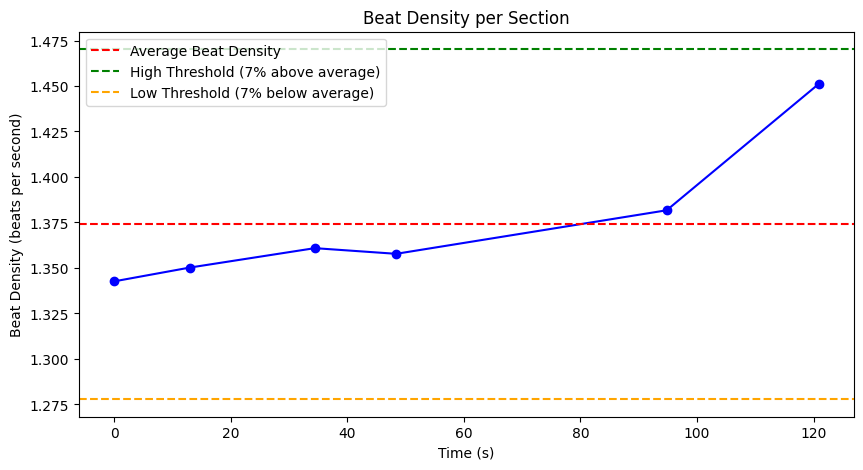

In [75]:
section_beat_density_threshold = analyze_section_beat_density_threshold(section_start_times, section_beat_densities, density_weight)

In [76]:
section_loudnesses, section_timbres = get_section_loudness_timbre(sections, audio_analysis)

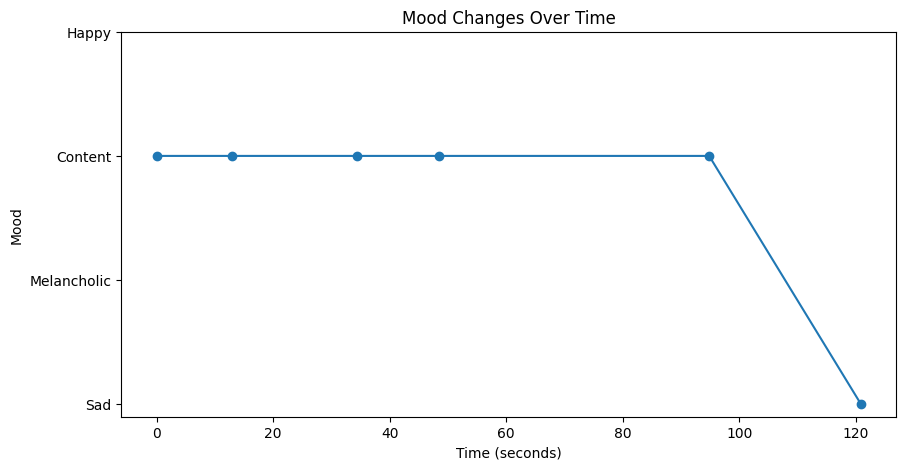

In [77]:
df = analyze_mood_over_sections(audio_features, sections, tempo_values)

- 음을 음의 높이에 맞춰 튀기자
- 공의 크기 -> 음의 세기 (intensity)
- 도형의 개수를 최소화 + 박자 = 선분 유지
- 장애물이 등장하는 스타일 = 곡의 전체적인 분위기

In [78]:
import librosa
from librosa import note_to_midi
from IPython.display import Audio

audio_file = 'musics/We Will Rock You (Movie Mix)-11-Que....mp3'
y, sr = librosa.load(audio_file)

section_pitch_values = []

def analyze_timbre(timbre_vector):
    characteristics = []
    
    if timbre_vector[2] < 0:
        characteristics.append('flat')
    elif timbre_vector[3] > 0.5:
        characteristics.append('strong attack')
    if timbre_vector[1] > 0:
        characteristics.append('bright')
    if timbre_vector[4] > 0:
        characteristics.append('resonant')
    
    if len(characteristics) == 0:
        return 'neutral'
    else:
        return ', '.join(characteristics)

for i in range(len(section_start_times) - 1):
    start = section_start_times[i]
    end = section_start_times[i + 1]
    beat_interval = 1 / section_beat_densities[i]
    
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    y_section = y[start_sample:end_sample]
    
    pitches, magnitudes = librosa.piptrack(y=y_section, sr=sr)
    section_pitches = []
    
    current_time = 0
    
    while current_time < (end - start):
        beat_frame = librosa.time_to_frames(current_time, sr=sr)
        
        if beat_frame < pitches.shape[1]:
            index = magnitudes[:, beat_frame].argmax()
            pitch = pitches[index, beat_frame]
            volume = magnitudes[index, beat_frame]
            
            if pitch > 0:
                note = librosa.hz_to_note(pitch)
                section_pitches.append((current_time + start, note, volume))
                
        current_time += beat_interval

    volumes = [volume for _, _, volume in section_pitches]
    
    if len(volumes) > 0:
        mean_volume = np.mean(volumes)
        std_volume = np.std(volumes)
        z_scores = (volumes - mean_volume) / std_volume
        threshold = -3 # for vibration
        threshold = 0 # for shapes
    else:
        threshold = 0
        z_scores = []

    filtered_pitches = [
        (time, note, volume) for (time, note, volume), z in zip(section_pitches, z_scores) if z >= threshold
    ]
    section_pitch_values.append((start, end, filtered_pitches))

timbre_data_per_pitch = []

for start, end, pitches in section_pitch_values:
    for time, note, volume in pitches:
        matching_segment = next((segment for segment in segments if segment['start'] <= time < (segment['start'] + segment['duration'])), None)

        if matching_segment:
            timbre_data_per_pitch.append((time, note, volume, matching_segment['timbre']))

pitch_characteristics = []

for time, note, volume, timbre_vector in timbre_data_per_pitch:
    timbre_characteristic = analyze_timbre(timbre_vector)
    pitch_characteristics.append((time, note, volume, timbre_characteristic))
    
    print(f"Pitch at {time:.2f}s ({note}): Timbre characteristic is {timbre_characteristic}")

# all_notes = sorted(set(note for _, note, _, _ in pitch_characteristics), key=lambda x: note_to_midi(x))
# note_to_index = {note: idx for idx, note in enumerate(all_notes)}

Pitch at 0.74s (D♯3): Timbre characteristic is flat
Pitch at 2.23s (A3): Timbre characteristic is flat
Pitch at 3.72s (D♯3): Timbre characteristic is flat
Pitch at 5.21s (F3): Timbre characteristic is flat
Pitch at 6.70s (E3): Timbre characteristic is flat
Pitch at 8.19s (F3): Timbre characteristic is flat
Pitch at 9.68s (D♯3): Timbre characteristic is flat
Pitch at 11.17s (D♯3): Timbre characteristic is flat
Pitch at 12.66s (D♯6): Timbre characteristic is bright
Pitch at 16.66s (E3): Timbre characteristic is bright, resonant
Pitch at 17.41s (G5): Timbre characteristic is strong attack, bright, resonant
Pitch at 18.15s (C6): Timbre characteristic is bright
Pitch at 18.89s (F5): Timbre characteristic is strong attack, bright, resonant
Pitch at 21.11s (F3): Timbre characteristic is bright
Pitch at 22.59s (E3): Timbre characteristic is flat, bright, resonant
Pitch at 24.07s (G4): Timbre characteristic is bright, resonant
Pitch at 24.81s (F♯4): Timbre characteristic is strong attack, brigh

In [79]:
merged_pitch_characteristics = []
i = 0

while i < len(pitch_characteristics):
    current_time, current_note, current_volume, current_characteristic = pitch_characteristics[i]
    # Merge "strong attack" pitches
    if 'strong attack' in current_characteristic:
        j = i + 1
        while j < len(pitch_characteristics):
            next_time, next_note, next_volume, next_characteristic = pitch_characteristics[j]
            if next_note == current_note and 'strong attack' not in next_characteristic:
                j += 1
            else:
                break
        if j > i + 1:
            current_characteristic = current_characteristic.replace('strong attack', 'flat')
        merged_pitch_characteristics.append((current_time, current_note, current_volume, current_characteristic))
        i = j
    else:
        merged_pitch_characteristics.append((current_time, current_note, current_volume, current_characteristic))
        i += 1

# Merge volumes based on the previous rules
i = 0
final_pitch_characteristics = []

while i < len(merged_pitch_characteristics):
    current_time, current_note, current_volume, current_characteristic = merged_pitch_characteristics[i]
    merged_volume = current_volume
    j = i + 1
    while j < len(merged_pitch_characteristics):
        next_time, next_note, next_volume, next_characteristic = merged_pitch_characteristics[j]
        if 'flat' in current_characteristic and current_note == next_note:
            merged_volume += next_volume
            j += 1
        elif 'flat' in next_characteristic and current_note == next_note:
            merged_volume += next_volume
            j += 1
        elif 'strong attack' not in current_characteristic and current_note == next_note and 'strong attack' not in next_characteristic:
            merged_volume += next_volume
            j += 1
        else:
            break
    final_pitch_characteristics.append((current_time, current_note, merged_volume, current_characteristic))
    i = j

# Get all unique notes across all sections to arrange y-axis
all_notes = sorted(set(note for _, note, _, _ in final_pitch_characteristics), key=lambda x: note_to_midi(x))

# Convert note labels to MIDI numbers for plotting
note_to_index = {note: idx for idx, note in enumerate(all_notes)}

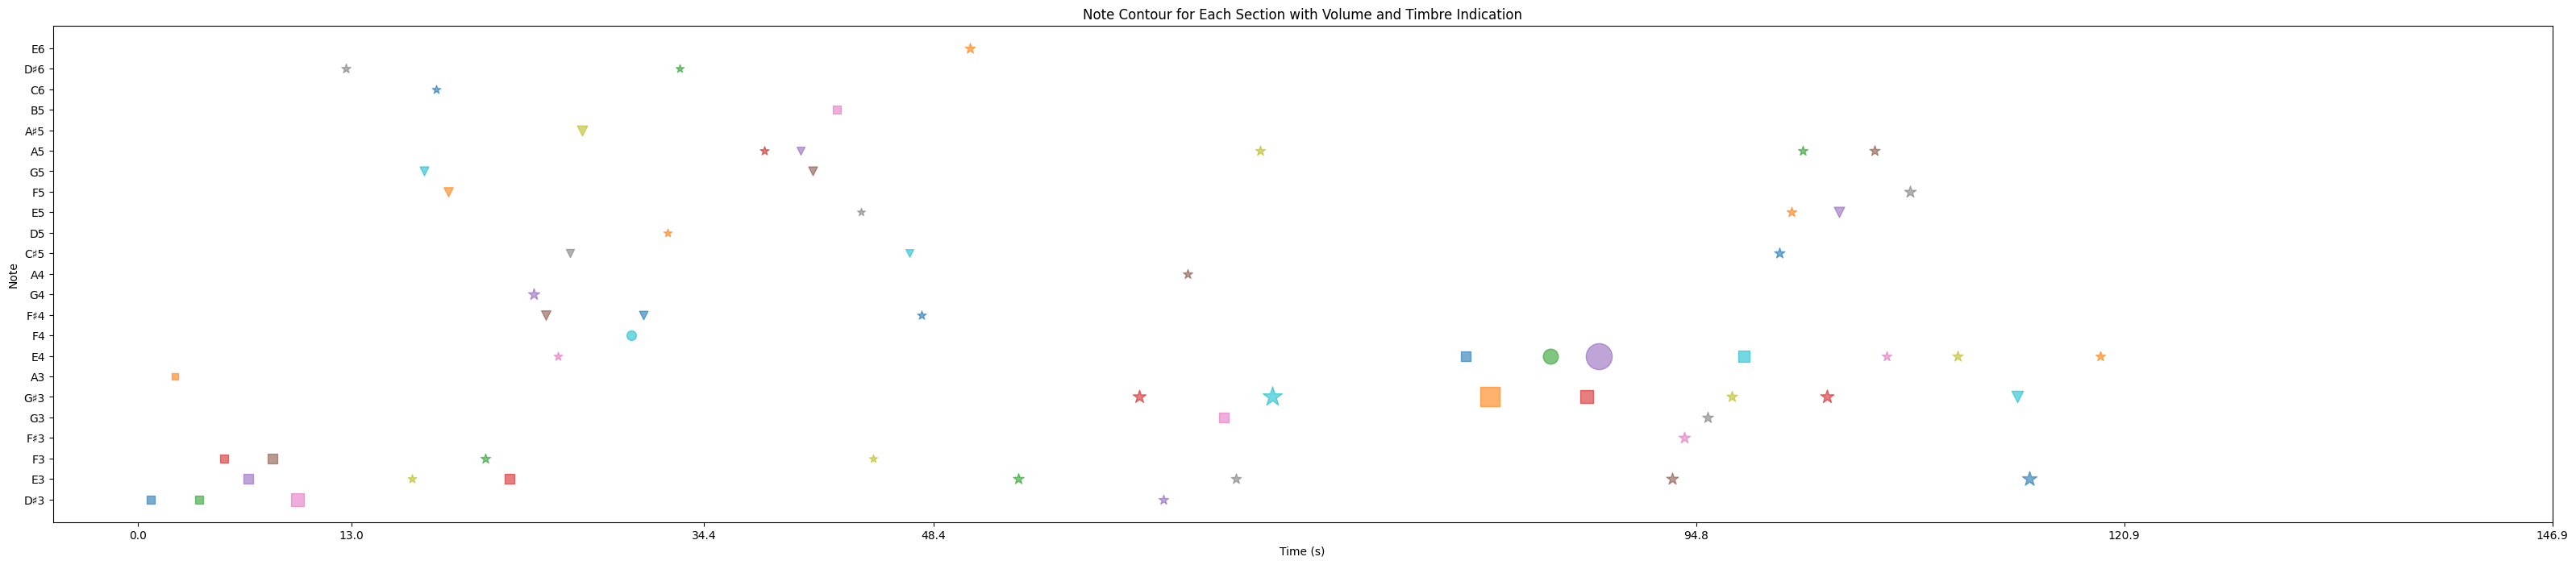

In [80]:
# Plot the pitch values for each section with correct time representation
plt.figure(figsize=(40, 8))
marker_dict = {
    'flat': 's',  # rectangle
    'strong attack': 'v',  # inverted triangle
    'bright': '*',  # glow
    'resonant': 'o',  # double circle
    'neutral': 'o'  # circle
}
for time, note, volume, characteristic in final_pitch_characteristics:
    marker = 'o'  # default marker for 'neutral'
    characteristics = characteristic.split(', ')
    for char in characteristics:
        if char in marker_dict:
            marker = marker_dict[char]
            break
    
    plt.scatter(time, note_to_index[note], s=volume, marker=marker, alpha=0.6)  # Use volume to scale the marker size

# Set x-axis ticks to include section start and end times
x_ticks = section_start_times + [section_start_times[-1] + (section_start_times[-1] - section_start_times[-2])]
plt.xticks(x_ticks)

# Set y-axis to show unique notes in sorted order by pitch
plt.yticks(ticks=range(len(all_notes)), labels=all_notes)

plt.xlabel('Time (s)')
plt.ylabel('Note')
plt.title('Note Contour for Each Section with Volume and Timbre Indication')
plt.show()

In [81]:
click_times = [time for time, _, _, _ in final_pitch_characteristics]
click_dynamic = librosa.clicks(times=click_times, sr=sr, click_freq=660, click_duration=0.25, length=len(y))

Audio(data=y + click_dynamic, rate=sr)

In [82]:
final_pitch_characteristics

[(np.float64(0.7448194117647059), 'D♯3', np.float32(49.86676), 'flat'),
 (np.float64(2.2344582352941176), 'A3', np.float32(33.310158), 'flat'),
 (np.float64(3.7240970588235296), 'D♯3', np.float32(45.251534), 'flat'),
 (np.float64(5.213735882352941), 'F3', np.float32(48.65855), 'flat'),
 (np.float64(6.703374705882352), 'E3', np.float32(75.3163), 'flat'),
 (np.float64(8.193013529411763), 'F3', np.float32(73.43994), 'flat'),
 (np.float64(9.682652352941174), 'D♯3', np.float32(122.63175), 'flat'),
 (np.float64(12.661929999999996), 'D♯6', np.float32(73.529816), 'bright'),
 (np.float64(16.664842068965516),
  'E3',
  np.float32(64.654945),
  'bright, resonant'),
 (np.float64(17.40548448275862),
  'G5',
  np.float32(62.21819),
  'strong attack, bright, resonant'),
 (np.float64(18.14612689655172), 'C6', np.float32(62.223145), 'bright'),
 (np.float64(18.886769310344825),
  'F5',
  np.float32(66.88953),
  'strong attack, bright, resonant'),
 (np.float64(21.108696551724137), 'F3', np.float32(81.120

In [83]:
!python lyrics_timestamp.py

2024-11-15 12:57:43.522595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731643063.542630 1620582 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731643063.548458 1620582 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 12:57:43.568659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/j-k11d203/.local/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:509: FutureWarn

In [84]:
f = open('./lyrics_timestamp.txt', 'r')

lyrics_timestamps = [x.strip() for x in f.readlines()]

f.close()

In [85]:
import ast

parsed_lyrics_timestamps = []
parsed_timestamps = []

for timestamp in lyrics_timestamps:
    parsed_lyrics_timestamps.append(ast.literal_eval(timestamp))
    parsed_timestamps.append((parsed_lyrics_timestamps[-1]["timestamp"][0], parsed_lyrics_timestamps[-1]["timestamp"][1] - parsed_lyrics_timestamps[-1]["timestamp"][0]))

In [86]:
parsed_timestamps

[(11.54, 0.8200000000000003),
 (12.36, 0.3200000000000003),
 (12.68, 0.040000000000000924),
 (12.72, 0.4599999999999991),
 (13.18, 0.14000000000000057),
 (13.32, 0.17999999999999972),
 (13.5, 0.2599999999999998),
 (13.76, 0.3800000000000008),
 (14.34, 0.22000000000000064),
 (14.56, 0.27999999999999936),
 (14.84, 0.120000000000001),
 (14.96, 0.4399999999999995),
 (15.4, 0.2400000000000002),
 (15.64, 0.2599999999999998),
 (15.9, 0.20000000000000107),
 (16.1, 0.259999999999998),
 (16.36, 0.3200000000000003),
 (16.68, 0.6000000000000014),
 (17.48, 0.09999999999999787),
 (17.58, 0.22000000000000242),
 (17.8, 0.35999999999999943),
 (18.16, 0.26000000000000156),
 (18.42, 0.23999999999999844),
 (18.66, 0.5199999999999996),
 (19.18, 0.240000000000002),
 (19.42, 0.1999999999999993),
 (19.62, 0.6999999999999993),
 (20.66, 0.5599999999999987),
 (21.22, 0.26000000000000156),
 (21.48, 0.3999999999999986),
 (21.88, 0.35999999999999943),
 (22.24, 0.4800000000000004),
 (22.72, 0.22000000000000242),
 (2

In [87]:
import json
from collections import OrderedDict

j = OrderedDict()
j["code"] = 200
j["data"] = {"vibrations": [], "notes": []}

for time, duration in parsed_timestamps:
    j["data"]["vibrations"].append({"time": time, "duration": duration})

In [88]:
j["data"]["vibrations"]

[{'time': 11.54, 'duration': 0.8200000000000003},
 {'time': 12.36, 'duration': 0.3200000000000003},
 {'time': 12.68, 'duration': 0.040000000000000924},
 {'time': 12.72, 'duration': 0.4599999999999991},
 {'time': 13.18, 'duration': 0.14000000000000057},
 {'time': 13.32, 'duration': 0.17999999999999972},
 {'time': 13.5, 'duration': 0.2599999999999998},
 {'time': 13.76, 'duration': 0.3800000000000008},
 {'time': 14.34, 'duration': 0.22000000000000064},
 {'time': 14.56, 'duration': 0.27999999999999936},
 {'time': 14.84, 'duration': 0.120000000000001},
 {'time': 14.96, 'duration': 0.4399999999999995},
 {'time': 15.4, 'duration': 0.2400000000000002},
 {'time': 15.64, 'duration': 0.2599999999999998},
 {'time': 15.9, 'duration': 0.20000000000000107},
 {'time': 16.1, 'duration': 0.259999999999998},
 {'time': 16.36, 'duration': 0.3200000000000003},
 {'time': 16.68, 'duration': 0.6000000000000014},
 {'time': 17.48, 'duration': 0.09999999999999787},
 {'time': 17.58, 'duration': 0.22000000000000242

In [89]:
width = 80
height = 80

note_order = {'C': 0, 'C♯': 1, 'D': 2, 'D♯': 3, 'E': 4, 'F': 5, 'F♯': 6, 'G': 7, 'G♯': 8, 'A': 9, 'A♯': 10, 'B': 11}
timestamp_gap = 0.5
minimum_flat_duration = 1.0

def note_value(note):
    return int(note[-1]) * 12 + note_order[note[:-1]]

stft = np.abs(librosa.stft(y))

pitch_index = 0
parsed_timestamp_index = 0

for i, section in enumerate(sections):
    d = OrderedDict()
    d["category" + str(i + 1)] = i + 2
    j["data"]["categories"].append(d)

    start = section["start"]
    end = start + section["duration"]
    
    s_pitches = []
    s_timestamps = []
    s_notes = set()
    
    for pitch_index in range(pitch_index, len(final_pitch_characteristics)):
        if final_pitch_characteristics[pitch_index][0] > end:
            break
        else:
            s_pitches.append(final_pitch_characteristics[pitch_index])
            s_notes.add(final_pitch_characteristics[pitch_index][1])

    for parsed_timestamp_index in range(parsed_timestamp_index, len(parsed_timestamps)):
        if parsed_timestamps[parsed_timestamp_index][0] > end:
            break
        else:
            s_timestamps.append(parsed_timestamps[parsed_timestamp_index])
    
    s_volume = np.mean([item[2] for item in s_pitches])
    s_notes_sorted = sorted(s_notes, key=note_value)
    s_meter = meter_values[i]

    ds = []

    for pitch in s_pitches:
        time, note, volume, timbre = pitch

        d = OrderedDict()
        d["section"] = i + 1
        d["time"] = time
        d["y"] = round(((s_notes_sorted.index(note) + 1) / len(s_notes_sorted)) * 100)
        d["height"] = round(width * (1 + volume / s_volume) / 2)
        d["width"] = d["height"]
        d["effect"] = []
        d["direction"] = (-1, 0)

        timbre = [x.strip() for x in timbre.split(',')]

        if timbre[0] == 'flat':
            d["sides"] = 4
            d["angle"] = 0
        elif timbre[0] == 'strong attack':
            d["sides"] = 3
            d["angle"] = 0.5
            d["direction"] = (0, -1)
        else:
            d["sides"] = 1
            d["angle"] = 0

        if 'bright' in timbre:
            d["effect"].append("GLOW")
        if 'resonant' in timbre:
            d["effect"].append("PING")

        ds.append(d)

    for timestamp in s_timestamps:
        stamp, duration = timestamp

        d = OrderedDict()
        d["section"] = i + 1
        d["time"] = stamp
        d["y"] = -1
        d["height"] = height
        d["width"] = round(height * (1 + duration / section["duration"]))
        d["effect"] = []
        d["direction"] = (-1, 0)
        d["duration"] = duration

        if duration < minimum_flat_duration:
            d["sides"] = 4
        else:
            d["sides"] = 1

        d["angle"] = 0

        ds.append(d)

    ds_sorted = sorted(ds, key=lambda d: d['time'])
    idx = 0
    
    while idx < len(ds_sorted):
        current = ds_sorted[idx]
        
        if current["y"] == -1:
            duration = current["duration"]
            copied = False
            
            if duration >= minimum_flat_duration:
                current["sides"] = 4
                idx2 = idx + 1
                
                while idx2 < len(ds_sorted):
                    if ds_sorted[idx2]["time"] <= current["time"] + duration:
                        if not copied:
                            current["y"] = ds_sorted[idx2]["y"]
                            current["height"] = ds_sorted[idx2]["height"]
                            current["width"] = round(current["height"] * (1 + duration / section["duration"]))
                            current["effect"] = ds_sorted[idx2]["effect"]
                            copied = True
                            
                        ds_sorted.pop(idx2)
                    else:
                        break
                
            current.pop("duration")
            
        idx += 1

    for td in ds_sorted:
        if td["y"] == -1:
            frame = librosa.time_to_frames(td["time"], sr=sr)

            if frame < stft.shape[1]:
                mgs = stft[:, frame]
                max_bin = np.argmax(mgs)
                fr = librosa.fft_frequencies(sr=sr)[max_bin]
                n = librosa.hz_to_note(fr)
                s_notes.add(n)
                td["note"] = n

    s_notes_sorted = sorted(s_notes, key=note_value)

    for td in ds_sorted:
        if td["y"] == -1:
            td["y"] = round(((s_notes_sorted.index(td["note"]) + 1) / len(s_notes_sorted)) * 100)
            td.pop("note")

    for td in ds_sorted:
        j["data"]["notes"].append(td)

print(json.dumps(j, ensure_ascii=False, indent="\t"))

{
	"code": 200,
	"data": {
		"categories": [
			{
				"defaultCategory": 1
			},
			{
				"category1": 2
			},
			{
				"category2": 3
			},
			{
				"category3": 4
			},
			{
				"category4": 5
			},
			{
				"category5": 6
			},
			{
				"category6": 7
			}
		],
		"vibrations": [
			{
				"time": 11.54,
				"duration": 0.8200000000000003
			},
			{
				"time": 12.36,
				"duration": 0.3200000000000003
			},
			{
				"time": 12.68,
				"duration": 0.040000000000000924
			},
			{
				"time": 12.72,
				"duration": 0.4599999999999991
			},
			{
				"time": 13.18,
				"duration": 0.14000000000000057
			},
			{
				"time": 13.32,
				"duration": 0.17999999999999972
			},
			{
				"time": 13.5,
				"duration": 0.2599999999999998
			},
			{
				"time": 13.76,
				"duration": 0.3800000000000008
			},
			{
				"time": 14.34,
				"duration": 0.22000000000000064
			},
			{
				"time": 14.56,
				"duration": 0.27999999999999936
			},
			{
				"time": 14.84,
				"duration": 0.120000000000001
			}

In [90]:
final_pitch_characteristics

[(np.float64(0.7448194117647059), 'D♯3', np.float32(49.86676), 'flat'),
 (np.float64(2.2344582352941176), 'A3', np.float32(33.310158), 'flat'),
 (np.float64(3.7240970588235296), 'D♯3', np.float32(45.251534), 'flat'),
 (np.float64(5.213735882352941), 'F3', np.float32(48.65855), 'flat'),
 (np.float64(6.703374705882352), 'E3', np.float32(75.3163), 'flat'),
 (np.float64(8.193013529411763), 'F3', np.float32(73.43994), 'flat'),
 (np.float64(9.682652352941174), 'D♯3', np.float32(122.63175), 'flat'),
 (np.float64(12.661929999999996), 'D♯6', np.float32(73.529816), 'bright'),
 (np.float64(16.664842068965516),
  'E3',
  np.float32(64.654945),
  'bright, resonant'),
 (np.float64(17.40548448275862),
  'G5',
  np.float32(62.21819),
  'strong attack, bright, resonant'),
 (np.float64(18.14612689655172), 'C6', np.float32(62.223145), 'bright'),
 (np.float64(18.886769310344825),
  'F5',
  np.float32(66.88953),
  'strong attack, bright, resonant'),
 (np.float64(21.108696551724137), 'F3', np.float32(81.120